# "Segmentez des clients d'un site e-commerce"
_Cleaning Notebook_

## 0 Preliminaries

In [4]:
# !pip install flake8 pycodestyle_magic
# !pip install gtts
# !pip install category-encoders
# !pip install mlxtend==0.17.3 # makes Google Colab asking for reboot
# !pip install ppscore

In [5]:
# !pip freeze > requirements_cleaning_eda.txt

Checking for PEP8 compliance

In [6]:
# %load_ext pycodestyle_magic
# %pycodestyle_on
# %pycodestyle_off

### 0.0 Importing Packages and Modules

Checking whether the notebook is on Colab or PC

In [7]:
import sys
is_colab = 'google.colab' in sys.modules
is_colab, sys.executable

(True, '/usr/bin/python3')

Mounting my Drive if on colab

In [8]:
if is_colab==True:
    from google.colab import files, output, drive
    drive.mount('/gdrive')
    %cd /gdrive
    print("You're on Google Colab")
else:
    print("You're on a PC")

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive
You're on Google Colab


Installations and importations required in the virtual environment.

In [9]:
import os
if is_colab==True:
    if os.getcwd()!='/gdrive/My Drive/--DATA SCIENCE/PROJET5/NOTEBOOKS':
        os.chdir('My Drive/--DATA SCIENCE/PROJET5/NOTEBOOKS')
else:
    if not (os.path.exists(os.getcwd()+'/requirements_cleaning_eda.txt') \
                     and os.path.exists(os.getcwd()+'/P5_functions.py')):
        print("ERROR: Make sure 'P5_functions.py' and 'requirements_cleaning_eda.txt' are in the current working directory")

!pip install -r requirements_cleaning_eda.txt
from P5_functions import *

     |████████████████████████████████| 112kB 2.8MB/s 
     |████████████████████████████████| 51kB 4.2MB/s 
     |████████████████████████████████| 153kB 7.2MB/s 
     |████████████████████████████████| 133kB 8.9MB/s 
     |████████████████████████████████| 6.5MB 8.7MB/s 
     |████████████████████████████████| 81kB 7.4MB/s 
     |████████████████████████████████| 51kB 5.4MB/s 
     |████████████████████████████████| 7.8MB 26.7MB/s 
     |████████████████████████████████| 163kB 40.5MB/s 
     |████████████████████████████████| 61kB 5.5MB/s 
     |████████████████████████████████| 143kB 42.9MB/s 
     |████████████████████████████████| 92kB 7.2MB/s 
     |████████████████████████████████| 81kB 6.0MB/s 
     |████████████████████████████████| 92kB 5.6MB/s 
     |████████████████████████████████| 3.4MB 42.4MB/s 
     |████████████████████████████████| 92kB 8.0MB/s 
     |████████████████████████████████| 4.2MB 48.7MB/s 
     |████████████████████████████████| 61kB 6.9MB/s 
     |████████

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Importation of modules and packages. 

In [10]:
import io
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.facecolor']='w'

Setting pandas display options

In [11]:
dictPdSettings = {'display.max_rows': 500, 'display.width': 100,
                  'display.max_colwidth': 100,
                  'display.float_format': lambda x: '%.2f' % x}
for k,v in dictPdSettings.items():
    pd.set_option(k,v)

To play audio text-to-speech during execution.

In [12]:
from IPython.display import Audio
from gtts import gTTS

def speak(text, lang='en'):
    with io.BytesIO() as f:
        gTTS(text=text, lang=lang).write_to_fp(f)
        f.seek(0)
        return Audio(f.read(), autoplay=True)

To check for existing pickles

In [13]:
import dill

def load_pickle(f_name):
# If file of models exists, open and load in dict_model
    if os.path.exists(f_name):
        with open(f_name, "rb") as f:
            d_file = dill.load(f)
        print('--Pickle already existing as ',
              f_name, ':\n', d_file.keys())
        print("Content loaded from '", f_name, "'.")
        return d_file
    # Else create an empty dictionary
    else:
        print('--No pickle yet as ',f_name)
        return {}

In [14]:
speak('Packages and modules successfully imported')

### 0.1 Importing the Aggregated Orders dataset

Let's load the dataframe of aggregated orders as well as the dataframe of aggregated customers.

This way, we'll be able to reconstruct the dataframe of customer on different slots of time later on.

In [15]:
if is_colab==True:
    # Importing database from my Drive
    print("Try to import data files in the notebook from myDrive...")
else:
    # Importing database from PC
    print("Try to import data files in the notebook from PC ('DATA')...")

df_cust = pd.read_csv('agg_customers.csv', sep=',', index_col='customer_unique_id',
                        encoding ='utf-8').drop(columns=['Unnamed: 0'])

df_orders = pd.read_csv('agg_orders.csv', sep=',', index_col='order_id',
                        encoding ='utf-8').drop(columns=['Unnamed: 0'])

print("-----> Importation of .csv in the notebook: OK")

Try to import data files in the notebook from myDrive...
-----> Importation of .csv in the notebook: OK


All the dates and timestamps in the dataframes are to be converted.

In [16]:
# Dates are converted in datetime format, and timedeltas in timedeltas
df_orders[['order_purchase_timestamp', 'max_limit_ship_date']] = \
    df_orders[['order_purchase_timestamp', 'max_limit_ship_date']]\
        .apply(lambda x: pd.to_datetime(x))
df_orders[['shipping_time', 'shipping_delay']] = \
    df_orders[['shipping_time', 'shipping_delay']]\
        .apply(lambda x: pd.to_timedelta(x))  
df_orders['cust_region'] = \
    df_orders['cust_region'].astype('object')

# Time in df_cust are already encoded in days (int)
df_cust['cust_region'] = \
    df_cust['cust_region'].astype('object')

In [17]:
df_orders.shape

(99441, 36)

In [18]:
df_orders.columns

Index(['customer_unique_id', 'cust_region', 'order_status', 'order_purchase_timestamp',
       'order_item_nb', 'product_volume_cm3', 'product_weight_g', 'mean_prod_descr_length',
       'shipping_time', 'shipping_delay', 'max_limit_ship_date', 'delivered', 'price',
       'freight_value', 'review_score', 'review_comment_length', 'payment_installments',
       'payment_value', 'paytype_boleto', 'paytype_credit_card', 'paytype_debit_card',
       'paytype_not_defined', 'paytype_voucher', 'cat_home', 'cat_furniture', 'cat_electronics',
       'cat_office', 'cat_diy', 'cat_food', 'cat_miscellaneous', 'cat_multimedia', 'cat_fashion',
       'cat_books', 'cat_hygiene', 'cat_unknown', 'cat_leisure'],
      dtype='object')

In [19]:
df_orders.dtypes.value_counts()

float64            28
object              3
timedelta64[ns]     2
datetime64[ns]      2
int64               1
dtype: int64

In [20]:
df_cust.dtypes.value_counts()

float64    34
int64       8
object      1
dtype: int64

In [21]:
speak('Dataset successfully imported')

## 1 Data selection and preprocessing

In [23]:
df_cust.columns

Index(['cust_region', 'mean_nb_items_per_ord', 'tot_nb_items', 'mean_freight_val_per_order',
       'tot_freight_val', 'mean_price_per_order', 'tot_price', 'tot_nb_deliv_ord',
       'avg_freight_payval_ratio', 'tot_nb_ord', 'mean_ship_delay', 'mean_ship_time',
       'single_purch', 'nb_not_rec_orders', 'time_since_last_purch', 'time_since_first_purch',
       'mean_prod_vol_cm3', 'tot_comment_length', 'mean_prod_descr_length', 'mean_prod_wei_g',
       'mean_comment_length', 'mean_rev_score', 'mean_pay_value_per_order', 'tot_pay_value',
       'paytype_not_defined_tot_nb', 'paytype_boleto_tot_nb', 'mean_pay_install',
       'paytype_voucher_tot_nb', 'paytype_debit_card_tot_nb', 'paytype_credit_card_tot_nb',
       'cat_multimedia_tot_nb', 'cat_office_tot_nb', 'cat_leisure_tot_nb', 'cat_home_tot_nb',
       'cat_food_tot_nb', 'cat_unknown_tot_nb', 'cat_diy_tot_nb', 'cat_electronics_tot_nb',
       'cat_furniture_tot_nb', 'cat_hygiene_tot_nb', 'cat_fashion_tot_nb',
       'cat_miscella

#### SELECTION A: ALL MAIN ASPECTS (satisfaction, shipping, product specif, RFM) 

13 features:

**Product related features**: 'mean_prod_descr_length', 'mean_prod_wei_g', 'mean_prod_vol_cm3'

**Shipping Related features**: 'mean_ship_delay', 'nb_not_rec_orders', 'avg_freight_payval_ratio',

**Satisfaction related features**: 'tot_comment_length', 'mean_rev_score',

**RFM related features**: 'time_since_last_purch', 'tot_price', 'mean_nb_items_per_ord', 'tot_nb_deliv_ord'

**Payment modalities**: 'mean_pay_install'


In [24]:
# Data selection
sel_cols_A = ['mean_prod_descr_length', 'mean_prod_wei_g', 'mean_prod_vol_cm3',
              'mean_ship_delay', 'avg_freight_payval_ratio', 'nb_not_rec_orders',
              'tot_comment_length','mean_rev_score', 'time_since_last_purch',
              'tot_price', 'mean_nb_items_per_ord', 'tot_nb_deliv_ord',
              'mean_pay_install']

#### SELECTION B: customer’s satisfaction, shipping and product/order specificities

9 features:

**Product/order related features**: 'mean_prod_descr_length', 'mean_prod_wei_g', 'mean_prod_vol_cm3', 'mean_nb_items_per_ord'

**Shipping Related features**: 'avg_freight_payval_ratio', 'mean_ship_delay', 'nb_not_rec_orders'

**Satisfaction related features**: 'tot_comment_length', 'mean_rev_score',


In [25]:
# Data selection
sel_cols_B = ['mean_prod_descr_length', 'mean_prod_wei_g', 'mean_prod_vol_cm3',
              'mean_ship_delay', 'avg_freight_payval_ratio', 'nb_not_rec_orders',
              'tot_comment_length', 'mean_rev_score', 'mean_nb_items_per_ord']

To make the clustering process easier, we'll use UMAP to transform the data prior to use the clustering algorithm.

#### SELECTION C: monetary aspects, recency and frequency

5 features: 

**Recency related**: 'time_since_last_purch',

**Frequency related**: 'mean_nb_items_per_ord', 'tot_nb_deliv_ord'

**Monetary related**: 'tot_price',

**Payment modalities** : 'mean_pay_install'

In [26]:
# Data selection
sel_cols_C = ['time_since_last_purch', 'tot_price', 'mean_nb_items_per_ord',
              'tot_nb_deliv_ord', 'mean_pay_install']

#### Preprocessing

To make the clustering process easier, we'll use UMAP to transform the data prior to use the clustering algorithm.

In [27]:
from umap import UMAP

def select_transform(df, sel_col, strat_quant='stand',
                     UMAP_transf=False, n_comp=None):

    ### Data to use for clusters analysis (untransformed)
    df_orig = df.copy('deep')
    # Data selection
    df_orig = df[sel_col]

    ### Data to use with clustering algorithms
    # Transformation prior to UMAP
    ct = CustTransformer(strat_quant=strat_quant)
    df_trans = ct.fit_transform(df_orig)   

    if UMAP_transf:
        # UMAP (same nb of components as nb of column in original dataset)
        n_comp = len(sel_col) if n_comp is None else n_comp
        umap = UMAP(n_components=n_comp, n_neighbors=15, min_dist=0.1,
                    init='spectral', random_state=14)
        df_trans = pd.DataFrame(umap.fit_transform(df_trans),
                                index=df_trans.index,
                                columns=['UMAP'+str(i) for\
                                         i in range(n_comp)])

    return df_trans, df_orig

## 2 Selection A: simple 'StandardScaler' transformation

In [3]:
from sklearn.cluster import KMeans

We'll use the selection A of the columns at first, with a simple standard scaler.

In [28]:
# selects and transforms the dataset
df, df_expl = select_transform(df_cust, sel_cols_A, strat_quant='stand',
                               UMAP_transf=False, n_comp=None)

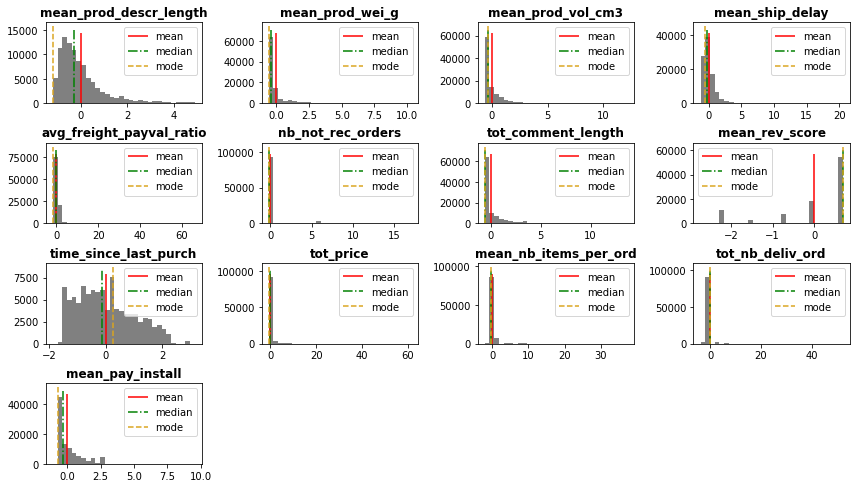

In [29]:
# Histograms of the untransformed data
plot_histograms(df=df_expl, cols=df_expl.columns,
                figsize=(12,15), bins=30, layout=(9,4))

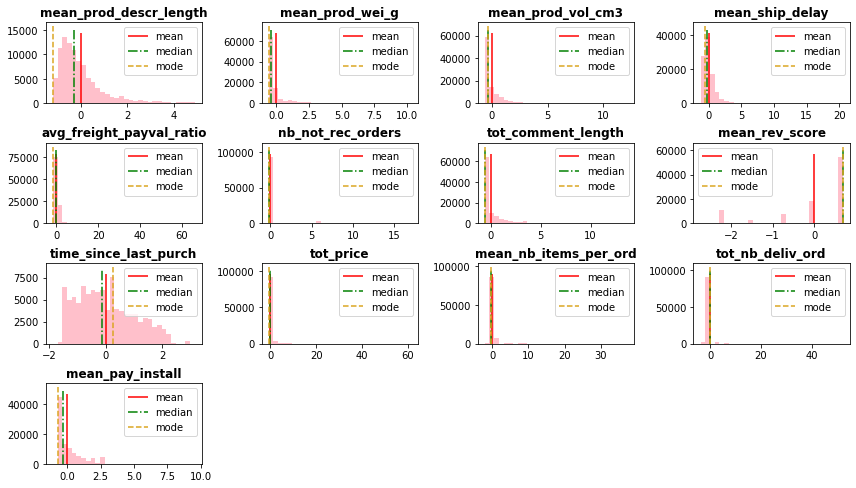

In [31]:
# Histograms of the transformed data
plot_histograms(df=df, cols=df.columns,
                figsize=(12,15), bins=30, color='pink', layout=(9,4))

### 2.0 Evaluation of sampling relevancy

Calculations on the whole database can take a lot of time.
We would like to take only a sample of the dataset, but we need to check:
- if a model fitted on a sample give the same clusters as one fitted onthe whole dataset
- if so, whether this is reproducible for any sample (independent of the choice)

To check this we will:
- train at first one model on the whole dataset ("whole model")
- train models with limited number of samples ("samples models") from 100 to 50000
- predict cluster labels of the whole dataset with each of these models
- compute the ARI score of the "whole model" predictions vs. "sample models" 

In [32]:
# Choosing a model
km_sampl = KMeans(n_clusters=6, random_state=14)
km_sampl.fit(df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=14, tol=0.0001, verbose=0)

In [33]:
from sklearn.model_selection import train_test_split

# Bining the mean review score column for further stratification (sampling)
bin_mean_review = pd.cut(df_cust['mean_rev_score'], [0,1,2,3,4,5])

In [34]:
# Checking the ARI score between predictions of the "whole model"
# vs. the "sample model", n_iter times.

n_iter=10
li_n_samp = [100, 250, 500, 750, 1000, 2000, 3000,
             4000, 5000, 7500, 10000, 20000, 50000]

df_ARI_all_vs_sample_iter = \
    check_ARI_through_sampling(km_sampl, df, li_n_samp,
                               n_iter=n_iter, stratify=bin_mean_review)

ooo ITERATION 0 ooo
ooo ITERATION 1 ooo
ooo ITERATION 2 ooo
ooo ITERATION 3 ooo
ooo ITERATION 4 ooo
ooo ITERATION 5 ooo
ooo ITERATION 6 ooo
ooo ITERATION 7 ooo
ooo ITERATION 8 ooo
ooo ITERATION 9 ooo


In [35]:
# Showing a summary of the ARI scores through iterations
pd.concat([df_ARI_all_vs_sample_iter.mean(1),
           df_ARI_all_vs_sample_iter.std(1), df_ARI_all_vs_sample_iter],
          axis=1).rename(columns={0:'mean', 1: 'std'})

,mean,std,iter_0,iter_1,iter_2,iter_3,iter_4,iter_5,iter_6,iter_7,iter_8,iter_9
"[all, 100_sampl]",0.45,0.19,0.27,0.26,0.46,0.21,0.48,0.50,0.67,0.65,0.26,0.69
"[all, 250_sampl]",0.43,0.16,0.32,0.36,0.36,0.61,0.64,0.15,0.42,0.39,0.40,0.67
"[all, 500_sampl]",0.55,0.20,0.86,0.66,0.72,0.35,0.37,0.40,0.68,0.76,0.28,0.44
"[all, 750_sampl]",0.51,0.17,0.38,0.38,0.34,0.76,0.64,0.42,0.72,0.73,0.44,0.33
"[all, 1000_sampl]",0.65,0.17,0.76,0.47,0.77,0.46,0.42,0.83,0.43,0.80,0.76,0.77
"[all, 2000_sampl]",0.67,0.17,0.80,0.77,0.43,0.82,0.44,0.75,0.77,0.76,0.74,0.38
"[all, 3000_sampl]",0.52,0.21,0.43,0.45,0.90,0.43,0.93,0.35,0.54,0.38,0.42,0.40
"[all, 4000_sampl]",0.76,0.18,0.76,0.84,0.42,0.86,0.43,0.81,0.77,0.93,0.83,0.91
"[all, 5000_sampl]",0.74,0.18,0.78,0.42,0.72,0.94,0.75,0.91,0.79,0.91,0.44,0.77
"[all, 7500_sampl]",0.76,0.21,0.94,0.76,0.44,0.93,0.92,0.80,0.75,0.92,0.35,0.79


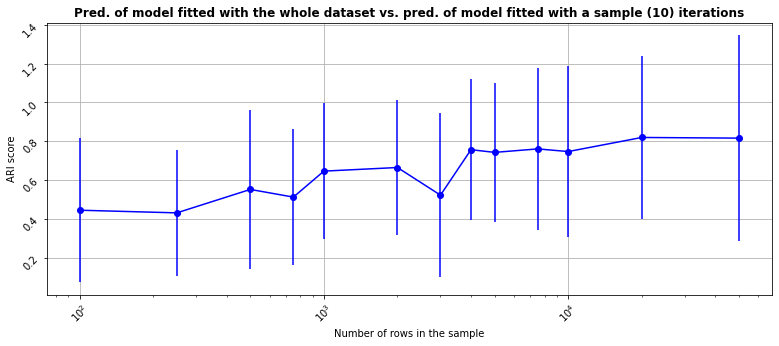

In [36]:
# Plotting the results

fig, ax = plt.subplots(1)
fig.set_size_inches(13,5)

ax.errorbar(li_n_samp,
            df_ARI_all_vs_sample_iter.mean(1).values,
            yerr=2*(df_ARI_all_vs_sample_iter.std(1).values),
            marker='o', color='blue')

ax.tick_params(rotation=45)
ax.set_xscale('log')
plt.xlabel("Number of rows in the sample")
plt.ylabel("ARI score")
plt.title(f"Pred. of model fitted with the whole dataset \
vs. pred. of model fitted with a sample ({n_iter}) iterations", fontweight='bold')
plt.grid()
plt.show()

We can consider that a model fitted on a stratified sample of 3000 give similar results as a model fitted on the whole dataset (ARI greater than 0.95)

In [37]:
df_sampl, _ = train_test_split(df, train_size=10000, stratify=bin_mean_review)
ind_samp = df_sampl.index

### 2.1 Optimisation of the number of clusters

As shown above, we can use a 3000 sample of the whole dataframe with high confidence degree.
This will make the optimization of the number of clusters easier.

In [38]:
df = df.loc[ind_samp]
df_expl = df_expl.loc[ind_samp]

#### Evaluation of the KMeans clustering scores

We'll try to find the best number of cluster against:

- **Silhouette score**: measures the difference between the intra-cluster and nearest-cluster mean square distances (to maximize)
- **Davies_Bouldin score**: measures the maximal ratio of dispersion of pairs of clusters to their distance (to minimize)
- **Calinski_Harabasz score**: the ratio of inter-cluster dispersion to intra-cluster dispersion (to maximize)
- **Distortion**: the mean sum of squared distances to centers (find an elbow)

NB: the error bar represents 2 times the standard deviation (+/- 2 sigma)

In [39]:
%%time

import dill

# If the results are not existing (pickle) then recomputes
# Returns:
# - the aggregated results (mean, median, std) of the 4 scores
# - the list of the clusters predicted for each iteration and number of clusters
# - the proportion (pct) of the clusters 

list_n_clust = range(2,9)
dict_pkl_A = {}
n_iter = 20
dict_scores_iter, dict_ser_clust_n_clust, dict_pop_perc_n_clust = \
                    compute_clust_scores_nclust(df,
                                                list_n_clust=list_n_clust,
                                                n_iter=n_iter,
                                                return_pop=True)

CPU times: user 3min 43s, sys: 1min 20s, total: 5min 4s
Wall time: 3min 43s


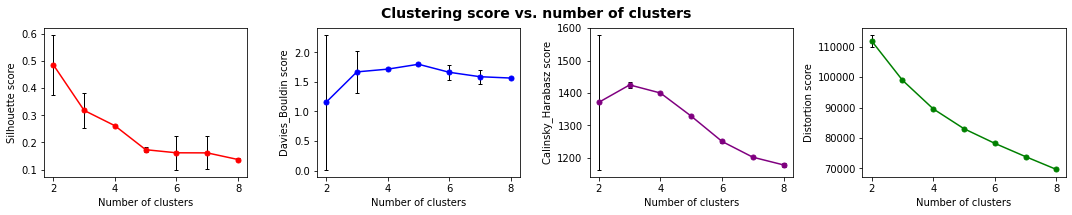

In [40]:
plot_scores_vs_n_clust(dict_scores_iter, figsize=(15,3))

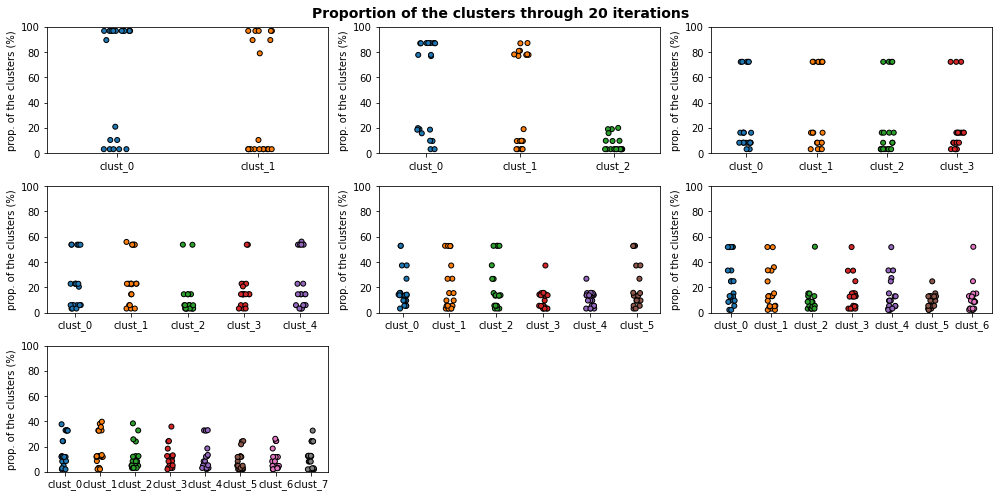

In [41]:
plot_prop_clust_vs_nclust(dict_pop_perc_n_clust, figsize=(14,7))

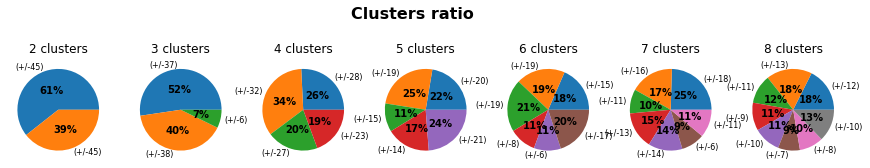

In [42]:
plot_clust_prop_pie_vs_nclust(dict_pop_perc_n_clust,
                              list_n_clust, figsize=(15, 3))

#### Silhouette scores of each cluster

Let's now see in more details the silhouette scores of each cluster, for the different number of clusters.

On the left part of the graph, the silhouette coefficient is plotted for each number of clusters:
- the length of the bands is proportionnal to the size of the cluster
- the width of the small bars are the distance of each point to the closest centroid

On the right a representation of the clusters on UMAP projection of the data.

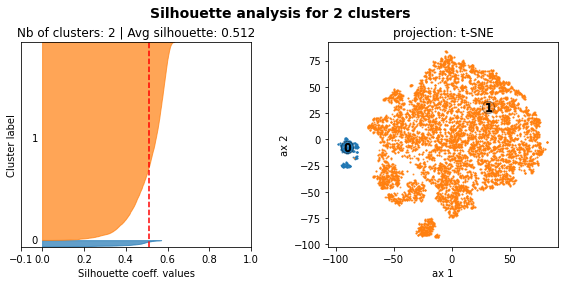

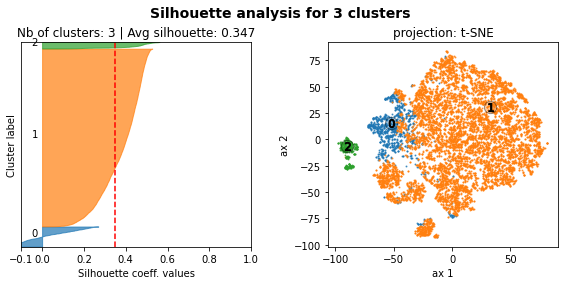

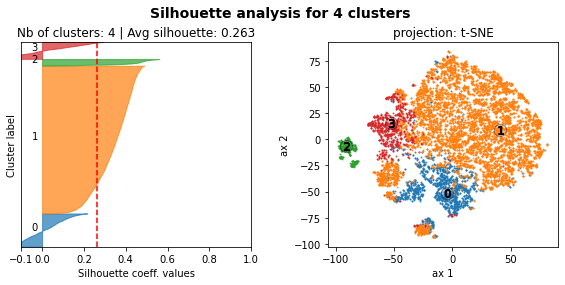

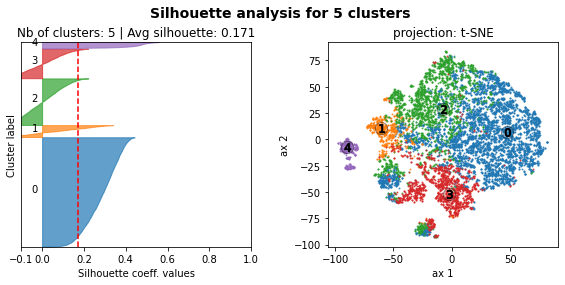

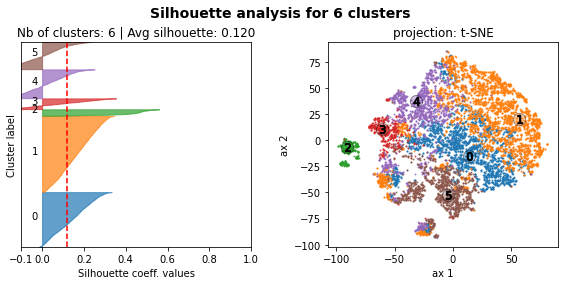

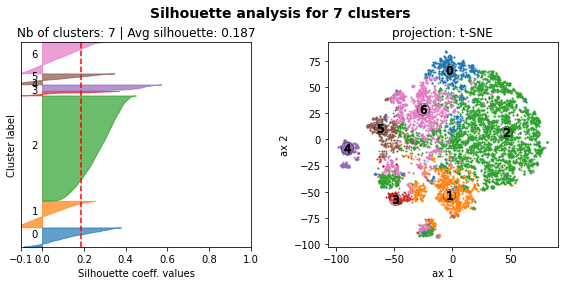

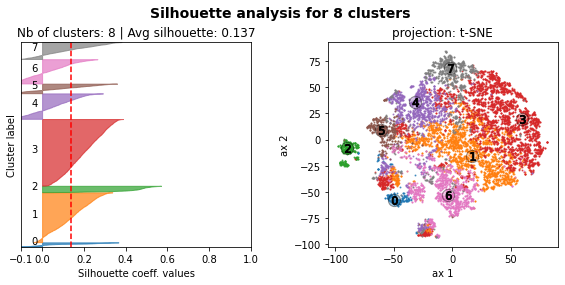

CPU times: user 30min 39s, sys: 18.5 s, total: 30min 58s
Wall time: 8min 19s


In [43]:
%%time

silh_scores_vs_n_clust(df, n_clust=list_n_clust, proj='t-SNE',
                       xlim=(-0.1,1), figsize=(8,4),
                       palette='tab10')

#### Checking for initialisation stability of the clusters

In [44]:
df_ARI_stab = pd.DataFrame()
for i in list_n_clust:
    print("ooooooooo Number of clusters: ", i)
    stab_init_kmeans = ARI_column_pairs(dict_ser_clust_n_clust[i],
                                        first_vs_others=False)
    df_ARI_stab = pd.concat([df_ARI_stab, stab_init_kmeans.to_frame()], axis=1)

ooooooooo Number of clusters:  2
--- ARI all 190 unique pairs ---
ARI: mean=0.771, std=0.317, min=0.169, max=1.000 
ooooooooo Number of clusters:  3
--- ARI all 190 unique pairs ---
ARI: mean=0.788, std=0.174, min=0.578, max=1.000 
ooooooooo Number of clusters:  4
--- ARI all 190 unique pairs ---
ARI: mean=0.997, std=0.002, min=0.994, max=1.000 
ooooooooo Number of clusters:  5
--- ARI all 190 unique pairs ---
ARI: mean=0.979, std=0.034, min=0.902, max=1.000 
ooooooooo Number of clusters:  6
--- ARI all 190 unique pairs ---
ARI: mean=0.738, std=0.264, min=0.458, max=1.000 
ooooooooo Number of clusters:  7
--- ARI all 190 unique pairs ---
ARI: mean=0.740, std=0.220, min=0.461, max=0.999 
ooooooooo Number of clusters:  8
--- ARI all 190 unique pairs ---
ARI: mean=0.740, std=0.245, min=0.336, max=0.999 


In [45]:
df_ARI_stab.sample(3)

,ARI_2_clust_all_pairs,ARI_3_clust_all_pairs,ARI_4_clust_all_pairs,ARI_5_clust_all_pairs,ARI_6_clust_all_pairs,ARI_7_clust_all_pairs,ARI_8_clust_all_pairs
"[iter_8, iter_17]",0.40,0.99,1.00,0.99,0.47,0.99,0.97
"[iter_12, iter_19]",1.00,0.73,1.00,1.00,0.46,0.94,0.35
"[iter_8, iter_13]",0.40,0.62,1.00,1.00,0.47,0.99,0.76


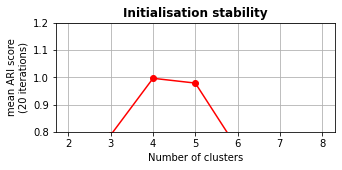

In [46]:
fig, ax = plt.subplots(1)
fig.set_size_inches(5,2)
ax.plot(list_n_clust, df_ARI_stab.mean(), '-or')
ax.set_xlabel('Number of clusters')
ax.set_ylabel(f'mean ARI score\n({n_iter} iterations)')
ax.set(ylim=(0.8,1.2))
ax.grid()
plt.title('Initialisation stability', fontweight='bold')
plt.show()

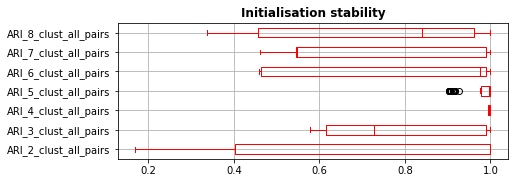

In [47]:
df_ARI_stab.boxplot(color='red', vert=False)
plt.gcf().set_size_inches(7,2.5)
plt.title('Initialisation stability', fontweight='bold')
plt.show()

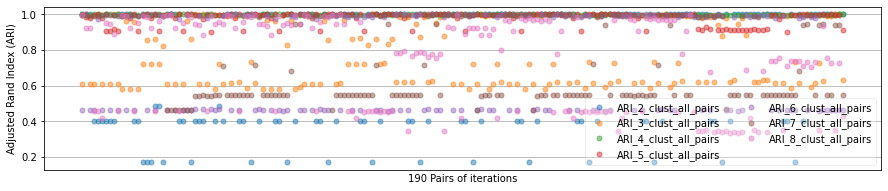

In [48]:
fig, ax = plt.subplots(1)
df_ARI_stab.plot(marker='o', markersize=5, linestyle='', alpha=0.5, ax=ax)
fig.set_size_inches(15,3)
ax.legend(ncol=2).get_frame().set_alpha(0.3)
ax.set_ylabel('Adjusted Rand Index (ARI)')
ax.set_xlabel(f'{df_ARI_stab.shape[0]} Pairs of iterations')
plt.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
plt.grid(axis='y')
plt.show()

### 2.2 Clusters analysis

We'll analyse the composition of the clusters given by the best model above fitted.

#### Visualisation of the best clusters

In [49]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# fit the model on the whole dataframe

n_clust = 4
best_model = KMeans(n_clusters=n_clust, n_jobs=-1, random_state=14)
best_model.fit(df)
ser_clust = pd.Series(data=best_model.labels_,
                      index=df.index)

silh = silhouette_score(X=df, labels=ser_clust)
dav_bould = davies_bouldin_score(X=df, labels=ser_clust)
cal_harab = calinski_harabasz_score(X=df, labels=ser_clust)
distor = best_model.inertia_
silh, cal_harab, dav_bould, distor

(0.26262316906462, 1400.1658555178562, 1.7214945429851878, 89588.26216546509)

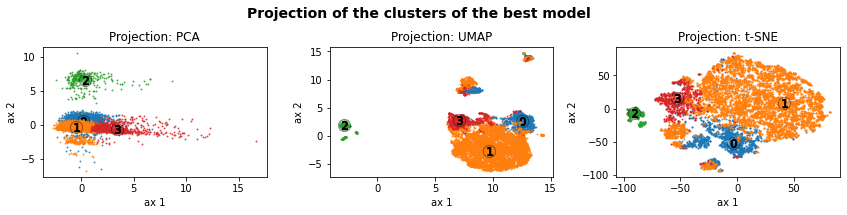

In [50]:
fig = plt.figure(figsize=(12,3))

tab_proj = ['PCA', 'UMAP', 't-SNE']
for i, proj in enumerate(tab_proj,1):
    ax = fig.add_subplot(1,len(tab_proj), i)
    # plot only a sample, but using the model already fitted
    plot_projection(df, model=best_model, proj=proj,
                    fig=fig, ax=ax)

fig.suptitle("Projection of the clusters of the best model",
            fontweight='bold', fontsize=14)
fig.tight_layout(rect=[0,0,1,0.92])
plt.show()

#### Contingency table, Chi square scores (clusters vs. binarized features)

In [51]:
best_model.fit(df)
ser_clust = pd.Series(best_model.labels_,
                        index=df.index,
                        name='clust')
df_expl_quant = df_expl.select_dtypes(include=[np.number])
ser_bin = pd.qcut(df_expl_quant[df_expl_quant.columns[0]], [0,0.2,0.4,0.6,0.8,1],
                            precision=2, duplicates='drop')


data_crosstab = pd.crosstab(ser_clust, ser_bin, margins = False)

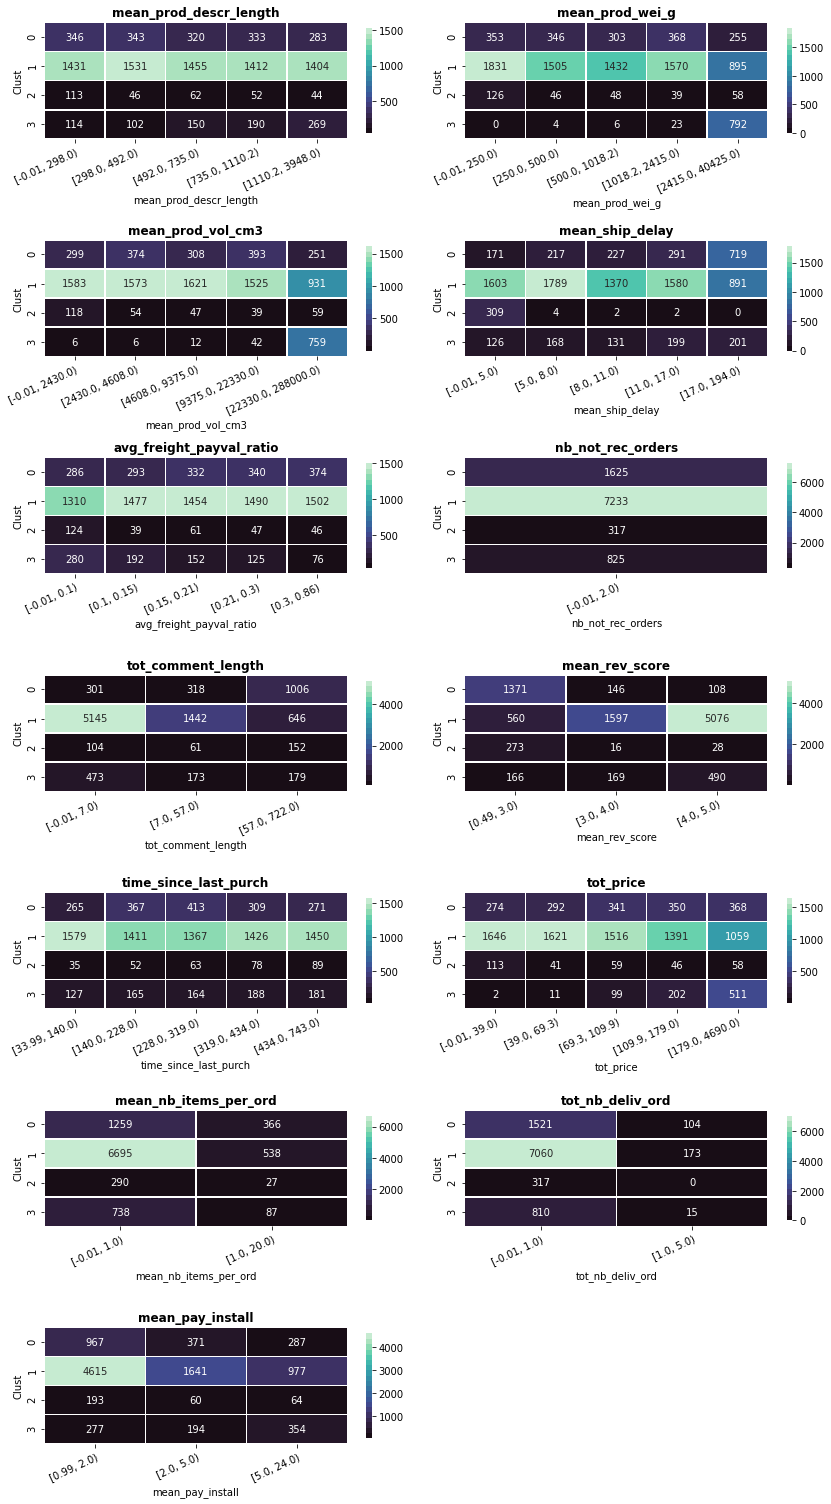

In [52]:
contingency_tables(best_model, df, df_expl, palette="mako",
                   cut_mode='quantile')

#### Relative difference of the mean

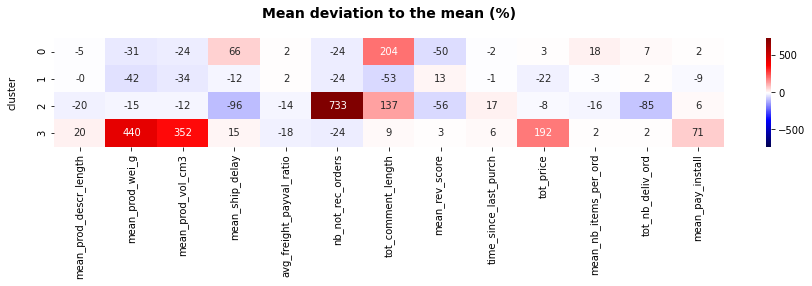

In [53]:
clust_mean, orig_df_mean, rel_var = mean_deviation_clust(best_model, df,
                                                         df_expl.loc[df.index],
                                                         palette='seismic',
                                                         figsize=(15,2))

#### Snake plots

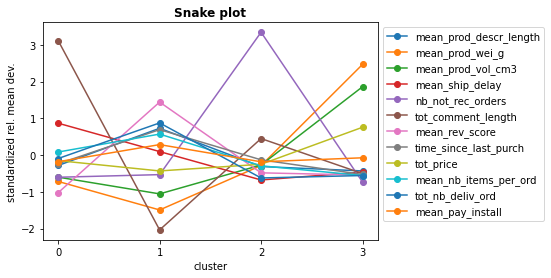

In [57]:
plot_snake(rel_var, thresh_dev=5)

#### ANOVA and Kruskal-Wallis test with quantitative data

Let's see if the quantitative columns are significant features of the clustering.

At first we'll plot the distribution of the quantitative features for each cluster as boxplots.

Then we'll see if the features are significantly different between the clusters.

In [59]:
# ANOVA and Kruskal-Wallis for each features against clusters

Anova_Kruskal_df = pd.DataFrame()
for i, col in enumerate(df_expl.columns,1):
    ser = test_distrib_clust(df_expl.assign(clust=ser_clust), col,
                       'clust', print_opt=False)
    Anova_Kruskal_df = pd.concat([Anova_Kruskal_df, ser.to_frame()], axis=1)

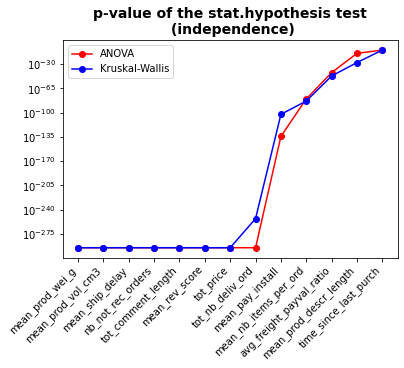

In [60]:
fig, ax = plt.subplots(1)

ser_anova = pd.Series([a for a,b in Anova_Kruskal_df.loc['ANOVA'].values],
          index = Anova_Kruskal_df.loc['ANOVA'].index,
          name='anova')
ser_kruskal = pd.Series([a for a,b in Anova_Kruskal_df.loc['Kruskal-Wallis'].values],
          index = Anova_Kruskal_df.loc['Kruskal-Wallis'].index,
          name='kruskal')
df_ = pd.concat([ser_anova, ser_kruskal], axis=1).sort_values('anova')

(df_['anova'].sort_values()+1e-295).plot(marker='o', color='red',
                                         label='ANOVA', ax=ax)
(df_['kruskal'].sort_values()+1e-295).plot(marker='o', color='blue',
                                           label='Kruskal-Wallis', ax=ax)

ax.set_yscale('log')
ax.set_xticklabels(df_.index)
plt.xticks(rotation=45, ha='right')
plt.xticks(np.arange(ser_anova.shape[0]))
plt.title('p-value of the stat.hypothesis test\n (independence)',
          fontweight='bold', fontsize='14')
plt.legend()
plt.show()

In [62]:
# Results (p-value, same distr or not) of ANOVA and Kruskal-Wallis tests
# for 'clust' vs. sel_col features

summary_ANOVA_Kruskal(df_expl.assign(clust=ser_clust),
                      C_col='clust', print_opt=False)

,mean_prod_descr_length,mean_prod_wei_g,mean_prod_vol_cm3,mean_ship_delay,avg_freight_payval_ratio,nb_not_rec_orders,tot_comment_length,mean_rev_score,time_since_last_purch,tot_price,mean_nb_items_per_ord,tot_nb_deliv_ord,mean_pay_install,clust
ANOVA,"(6.227746479253906e-15, 'False')","(0.0, 'False')","(0.0, 'False')","(0.0, 'False')","(1.0673448238316058e-42, 'False')","(0.0, 'False')","(0.0, 'False')","(0.0, 'False')","(3.245295441926278e-10, 'False')","(0.0, 'False')","(9.376942055184124e-81, 'False')","(0.0, 'False')","(8.248346523941951e-135, 'False')","(nan, 'False')"
Kruskal-Wallis,"(3.371695229208234e-28, 'False')","(0.0, 'False')","(0.0, 'False')","(0.0, 'False')","(1.317196972427465e-47, 'False')","(0.0, 'False')","(0.0, 'False')","(0.0, 'False')","(3.396743731069092e-10, 'False')","(1.1086336381304653e-253, 'False')","(4.986680264227284e-103, 'False')","(0.0, 'False')","(8.757758245172128e-84, 'False')","(0.0, 'False')"


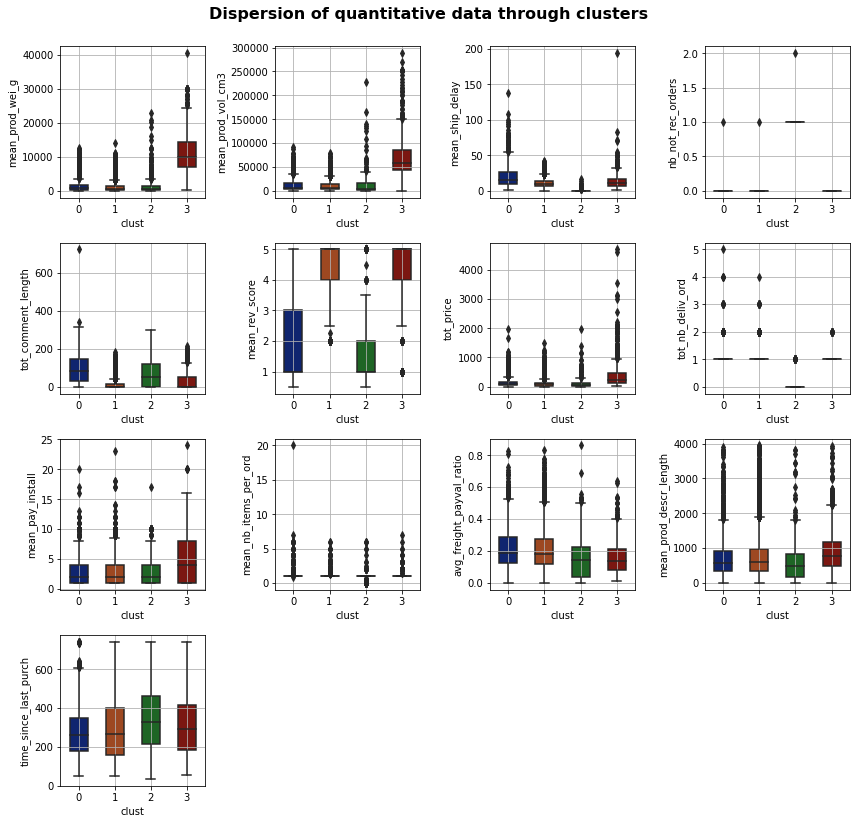

In [63]:
# Plotting boxplot of quantitative features for each cluster
# NB: col_order -> to keep the order of the lower p-value first
plot_boxplots_feat_vs_clust(df, df_expl, best_model, col_order=df_.index)

#### Radar charts

In [64]:
ser_clust = best_model.labels_

# DataFrame with the values of each columns for each cluster centroid
df_centroids = pd.DataFrame(best_model.cluster_centers_,
                            index=pd.Index(range(best_model.cluster_centers_.shape[0]),
                                           name='clust'),
                            columns=df.columns)

# DataFrame with the means of each columns for each cluster
df_clust = df_expl.assign(clust=ser_clust)\
    .reindex(columns=['clust']+list(df_expl.columns))
df_clust_mean = df_clust.groupby('clust').mean()

display(df_clust_mean, df_centroids)

,mean_prod_descr_length,mean_prod_wei_g,mean_prod_vol_cm3,mean_ship_delay,avg_freight_payval_ratio,nb_not_rec_orders,tot_comment_length,mean_rev_score,time_since_last_purch,tot_price,mean_nb_items_per_ord,tot_nb_deliv_ord,mean_pay_install
clust,,,,,,,,,,,,,
0,742.73,1404.76,11569.12,19.37,0.21,0.00,90.32,1.98,283.09,144.42,1.35,1.08,3.03
1,776.38,1174.95,10025.51,10.19,0.21,0.00,13.96,4.61,285.10,108.35,1.09,1.03,2.71
2,619.82,1738.05,13439.80,0.39,0.16,1.00,70.37,1.74,337.73,128.81,0.93,0.07,3.17
3,932.32,11026.37,68796.66,13.41,0.15,0.00,32.43,4.20,304.63,407.50,1.15,1.02,5.18


,mean_prod_descr_length,mean_prod_wei_g,mean_prod_vol_cm3,mean_ship_delay,avg_freight_payval_ratio,nb_not_rec_orders,tot_comment_length,mean_rev_score,time_since_last_purch,tot_price,mean_nb_items_per_ord,tot_nb_deliv_ord,mean_pay_install
clust,,,,,,,,,,,,,
0,-0.05,-0.18,-0.15,0.79,0.09,-0.17,1.18,-1.53,-0.03,0.01,0.41,0.27,0.02
1,-0.00,-0.25,-0.22,-0.16,0.04,-0.18,-0.32,0.41,-0.02,-0.15,-0.08,0.08,-0.09
2,-0.24,-0.09,-0.07,-1.18,-0.35,5.57,0.79,-1.71,0.33,-0.06,-0.38,-3.48,0.07
3,0.24,2.39,2.31,0.17,-0.39,-0.18,0.05,0.10,0.11,1.22,0.04,0.05,0.81


In [69]:
### CENTROIDS
#########################
my_dpi = 96

fig = plt.figure(figsize=(1000/my_dpi, 700/my_dpi),
                 dpi=my_dpi)

# Create a color palette:
my_palette = plt.cm.get_cmap("Dark2", len(df_centroids.index))

# # Loop to plot
for i, row in enumerate(df_centroids.index, 1):
    ax = fig.add_subplot(2,n_clust,i, polar=True)
    plot_radar_chart(df=df_centroids, row=row,
                     title='cluster '+str(row),
                     color=my_palette(row),
                     min_max_scaling=True, ax=ax)
plt.tight_layout()

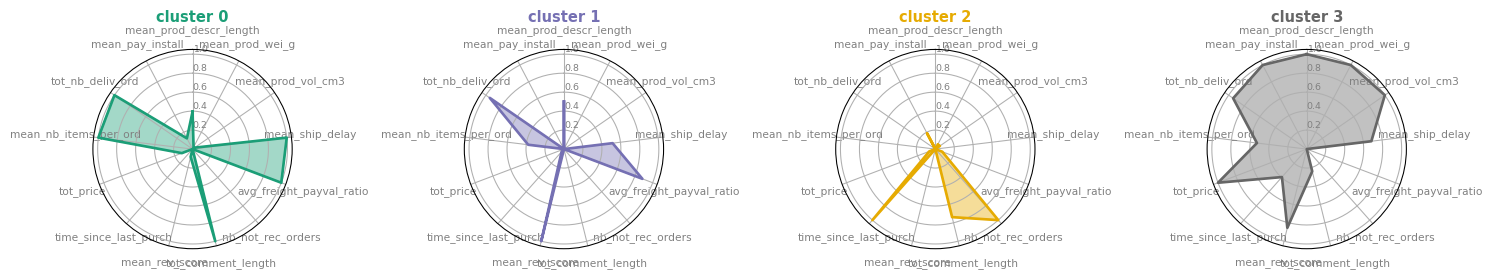

In [71]:
### MEAN UNTRANSFORMED DATA
###########################
my_dpi = my_dpi
fig = plt.figure(figsize=(1500/my_dpi, 500/my_dpi),
                 dpi=my_dpi)

# Loop to plot
for i, row in enumerate(df_clust_mean.index, 1):
    ax = fig.add_subplot(2,4,i, polar=True)
    plot_radar_chart(df=df_clust_mean, row=row,
                     title='cluster '+str(row),
                     color=my_palette(row),
                     min_max_scaling=True, ax=ax)
plt.tight_layout() # rect=[0,0,1,0.95]

#### Decision tree

To have an idea of the most important features in our clustering, we can train a decision tree, and see the feature importances using the 'feature \_importances\_' attribute.

NB: no standardization of data is required.

In [72]:
thresh_dev = 0
sel_col = rel_var[np.abs(rel_var)>thresh_dev].dropna(how='all', axis=1).columns
sel_col = [col for col in sel_col if not 'cat_' in col]

In [85]:
# NB: df_clust is the untransformed database with clustering result at the end
X_tr, y_tr = df_clust.iloc[:,1:], df_clust.iloc[:,0]

In [86]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(max_depth=6, random_state=14)
tree = tree.fit(X_tr, y_tr)

In [88]:
feature_importances = pd.Series(tree.feature_importances_,
                                index = X_tr.columns,
                                name='Feature importance')\
                                .sort_values(ascending=False)
feature_importances

mean_rev_score             0.42
mean_prod_wei_g            0.24
nb_not_rec_orders          0.13
tot_comment_length         0.12
mean_prod_vol_cm3          0.04
mean_ship_delay            0.03
mean_pay_install           0.01
tot_price                  0.01
tot_nb_deliv_ord           0.00
mean_nb_items_per_ord      0.00
time_since_last_purch      0.00
avg_freight_payval_ratio   0.00
mean_prod_descr_length     0.00
Name: Feature importance, dtype: float64

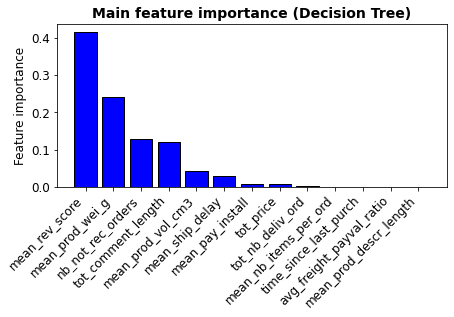

In [89]:
fig = plt.figure(figsize=(7, 3))
n_feat = feature_importances.shape[0]

ax = fig.add_subplot(111)
ax.set_ylabel('Feature importance', fontsize=12)
ax.set_title('Main feature importance (Decision Tree)',
             fontsize=14, fontweight='bold')
ax.tick_params(axis='both', which='major', labelsize=12)

plt.bar(range(n_feat), feature_importances, color='b', ec='k')

plt.xticks(range(n_feat), 
           feature_importances.index,
           ha='right',
           rotation=45, fontsize=12)

plt.show()

### 2.3 Clusters stability over time

#### Databases generation over increasing slots of time

In [90]:
t_first = df_orders['order_purchase_timestamp'].min()
t_last = df_orders['order_purchase_timestamp'].max()

print("First command of the order database: ", t_first)
print("Last command of the order database: ", t_last)

First command of the order database:  2016-09-04 21:15:19
Last command of the order database:  2018-10-17 17:30:18


The orders are spread over a range of time from september 4th to october 17th, i.e. 26 months.

To evaluate the stability of the clusters, we are going to follow the evolution of the customers whose first order has been placed during the first year.

We'll attribute a cluster to each of the customers that have purchased during the first year. We will then fit again the clustering algorithm, adding the customers of each following month, month per month. We'll check the rate of custumers of the first year that have changed cluster by computing the ARI score between old clusters and new clusters.

In [91]:
''' Generates the df_customers database for customers from df_orders with
order purchase timestamps from t_min to t_max
NB: if t_min and t_max are None, the whole df_orders dataframe is considered'''

def generate_cust_df(df_orders, t_min=None, t_max=None):
    df_cust = create_agg_cust_df(df_orders, t_min=t_min, t_max=t_max)
    df_cust = create_features_cust_df(df_cust)
    return df_cust

In [92]:
# loading the pickled dataframes if already existing
# or create an empty dictionnary

dict_df_cust = load_pickle("P5_dict_df_cust.pkl")

--Pickle already existing as  P5_dict_df_cust.pkl :
 dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])
Content loaded from ' P5_dict_df_cust.pkl '.


In [93]:
if dict_df_cust == {}: 

    # Aggregation of the df_cust databases for the first year and an increasing
    # period of time (adding month per month)
    # NB: df_cust database of the 1st year is the 1st dataframe of the list

    t_min = pd.Timestamp('2016-09-04 00:00:00')
    t_max = pd.Timestamp('2017-09-04 00:00:00')

    # Generation of the dataframes, stored in a dictionary
    days=0
    i=0
    dict_df_cust = {}
    while (t_max + timedelta(days=days)) < t_last:
        t_end = (t_max + timedelta(days=days))
        dict_df_cust[i] = \
            (generate_cust_df(df_orders, t_min=t_min, t_max=t_end),
            (t_min.strftime("%y/%m/%d"), t_end.strftime("%y/%m/%d")))
        days+=30.42 # mean number of days in one month
        i+=1
    print("{} databases were generated, with 'end_time' from {} to {}"\
        .format(i, t_max.strftime("%y/%m/%d"), t_end.strftime("%y/%m/%d")))

    # Storing the dictionary in a pickle
    with open("P5_dict_df_cust.pkl", "wb") as f:
        dill.dump(dict_df_cust, f)
    print("-----...dataframes dumped")
else:
    print("-----Object already existing")
    for k, v in dict_df_cust.items():
        print(f"dataframe n°{k}, dates: {v[1]}, shape: {v[0].shape}")

-----Object already existing
dataframe n°0, dates: ('16/09/04', '17/09/04'), shape: (23016, 43)
dataframe n°1, dates: ('16/09/04', '17/10/04'), shape: (27250, 43)
dataframe n°2, dates: ('16/09/04', '17/11/03'), shape: (31579, 43)
dataframe n°3, dates: ('16/09/04', '17/12/04'), shape: (39250, 43)
dataframe n°4, dates: ('16/09/04', '18/01/03'), shape: (44404, 43)
dataframe n°5, dates: ('16/09/04', '18/02/03'), shape: (51493, 43)
dataframe n°6, dates: ('16/09/04', '18/03/05'), shape: (58542, 43)
dataframe n°7, dates: ('16/09/04', '18/04/04'), shape: (65433, 43)
dataframe n°8, dates: ('16/09/04', '18/05/05'), shape: (72280, 43)
dataframe n°9, dates: ('16/09/04', '18/06/04'), shape: (78447, 43)
dataframe n°10, dates: ('16/09/04', '18/07/05'), shape: (84567, 43)
dataframe n°11, dates: ('16/09/04', '18/08/04'), shape: (90807, 43)
dataframe n°12, dates: ('16/09/04', '18/09/04'), shape: (96091, 43)
dataframe n°13, dates: ('16/09/04', '18/10/04'), shape: (96095, 43)


We'll select and transform the features of each database and store them in two separate dictionaries.

The chosen transformation is encapsulated in the 'select_transform' function : 

In [94]:
''' Takes the 'dict_df_cust' containing the whole dataframe for eahc period
of time, then select and transform df_cust of each period and return transformed
and untransformed versions of the dictionnary ('dict_df_trans', 'dict_df_orig')
'''

def sel_trans_dict_periods(dict_df_cust,
                           sel_cols, strat_quant='quant_norm',
                           UMAP_transf=False, n_comp=4, print_opt=True):
    dict_df_trans, dict_df_orig = {}, {}
    # Transforming the dataframes
    for k, v in dict_df_cust.items():
        df_ = v[0] # the dataframe
        name_ = v[1] # the name
        if print_opt: print(f'computing the df_trans and df_orig\
         for period {k}: {name_}')
        df_trans, df_orig = select_transform(df_, sel_cols,
                                             strat_quant=strat_quant,
                                             UMAP_transf=False, n_comp=n_comp)
        dict_df_trans[k] = (df_trans, name_)
        dict_df_orig[k] = (df_orig, name_)
    return dict_df_trans, dict_df_orig

In [95]:
params_sel_trans = {'sel_cols': sel_cols_A ,
                    'strat_quant': 'stand',
                    'UMAP_transf': False,
                    'n_comp': None}
dict_df_trans, dict_df_orig = \
    sel_trans_dict_periods(dict_df_cust, **params_sel_trans, print_opt=True)

computing the df_trans and df_orig         for period 0: ('16/09/04', '17/09/04')
computing the df_trans and df_orig         for period 1: ('16/09/04', '17/10/04')
computing the df_trans and df_orig         for period 2: ('16/09/04', '17/11/03')
computing the df_trans and df_orig         for period 3: ('16/09/04', '17/12/04')
computing the df_trans and df_orig         for period 4: ('16/09/04', '18/01/03')
computing the df_trans and df_orig         for period 5: ('16/09/04', '18/02/03')
computing the df_trans and df_orig         for period 6: ('16/09/04', '18/03/05')
computing the df_trans and df_orig         for period 7: ('16/09/04', '18/04/04')
computing the df_trans and df_orig         for period 8: ('16/09/04', '18/05/05')
computing the df_trans and df_orig         for period 9: ('16/09/04', '18/06/04')
computing the df_trans and df_orig         for period 10: ('16/09/04', '18/07/05')
computing the df_trans and df_orig         for period 11: ('16/09/04', '18/08/04')
computing the 

#### Method 1: Following customers of the first year with the same model (using .predict)

We'll compute for each database, the clusters attributed by our best model, fitted only once with the first database.

In [96]:
dict_df_trans[0][0].shape

(23016, 13)

In [97]:
# Indexes of the customers of the first year
ind_1st_year = dict_df_trans[0][0].index

In [98]:
# Fitting the model on the database of the first year only
best_model = KMeans(n_clusters=n_clust, random_state=14)
best_model.fit(dict_df_trans[0][0])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=14, tol=0.0001, verbose=0)

In [100]:
# Computing the cluster label of each customer of the 1st year for each period

df_clust_1st_year = pd.DataFrame()
for k, v in dict_df_trans.items():
    df_ = v[0] # database of period k
    name_ = v[1] # name of period k
    ser_clust = pd.Series(best_model.predict(df_),
                          index=df_.index,
                          name=f'{k}_clust_'+str(name_))
    ser = ser_clust.loc[ind_1st_year]
    df_clust_1st_year = pd.concat([df_clust_1st_year, ser.to_frame()],
                                  axis=1)

Here are the clusters labels predicted by the first model through time:

In [101]:
df_clust_1st_year.sample(3)

,"0_clust_('16/09/04', '17/09/04')","1_clust_('16/09/04', '17/10/04')","2_clust_('16/09/04', '17/11/03')","3_clust_('16/09/04', '17/12/04')","4_clust_('16/09/04', '18/01/03')","5_clust_('16/09/04', '18/02/03')","6_clust_('16/09/04', '18/03/05')","7_clust_('16/09/04', '18/04/04')","8_clust_('16/09/04', '18/05/05')","9_clust_('16/09/04', '18/06/04')","10_clust_('16/09/04', '18/07/05')","11_clust_('16/09/04', '18/08/04')","12_clust_('16/09/04', '18/09/04')","13_clust_('16/09/04', '18/10/04')"
customer_unique_id,,,,,,,,,,,,,,
90554d4d6a1bcd53a2138107c0959d8e,2,2,2,2,2,2,2,2,2,2,2,2,2,2
5d180ffdc0b416638fc305af59e5fce1,2,2,2,2,2,2,2,2,2,2,2,2,2,2
809d6dfb4365b8dd803181325337e741,3,3,3,3,3,3,3,3,3,3,3,3,3,3


Customers seem to have the same clusters labels through time.

Let's try to quantify the changes from one cluster to another with the adjusted Rand index (ARI) for differents periods of time.

In [102]:
nb_cust_1st_yr = df_clust_1st_year.shape[1]

ser_ARI_1_month = \
    ARI_column_pairs(df_clust_1st_year,
                     first_vs_others=True, print_opt=True)

--- ARI between first and the 13 others ---
ARI: mean=0.954, std=0.020, min=0.924, max=0.986 


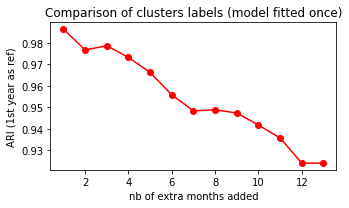

In [103]:
fig = plt.figure(figsize=(5,3))

ax = fig.add_subplot(111)
ax.plot(range(1, 14), ser_ARI_1_month.values, '-or')
ax.set_xlabel('nb of extra months added')
ax.set_ylabel('ARI (1st year as ref)')
plt.title('Comparison of clusters labels (model fitted once)')
plt.tight_layout()
plt.show()

Clusters tend to change more when more time elapses, however, ARI scores greater than 0.95 show that customers remain mostly is the same clusters.

Let's visualize now the flows of customers from one period to another with a Sankey diagram.

In [104]:
# Computing flow data and plotting the Sankey diagram
title="Sankey Diagram showing flows of customers from one period to another\
 - (model fitted once)"
all_flows = plot_Sankey_diagram(df_clust_1st_year, title=title)

#### Method 2: Following customers of the first year with a new model for each period of time

We'll fit a new model for each database (each period of time), then we'll store the clusters attributed by each models to the customers of the first year.

In [106]:
# Computing the cluster label of each customer for each period

# first initialisation
init_kmeans = 'k-means++'

df_clust_1st_year = pd.DataFrame()

for k, v in dict_df_trans.items():
    df_ = v[0] # database of period k
    name_ = v[1] # name of period k
    n_init = 10 if k==0 else 1 # to avoid warning
    # initialisation of a new model with init using centroids of the last period
    model = KMeans(n_clusters=n_clust, init=init_kmeans,
                   n_init=n_init, random_state=14)
    # refitting the model for each period of time (with new customers)
    model.fit(df_)
    # computing cluster_centers for more accurate fitting on the next period
    init_kmeans = model.cluster_centers_
    # getting labels of all the customers of the period
    ser_clust = pd.Series(model.labels_,
                          index=df_.index,
                          name=f'{k}_clust_'+str(name_))
    # storing only labels of the customers of 1st year
    ser = ser_clust.loc[ind_1st_year]
    df_clust_1st_year = pd.concat([df_clust_1st_year, ser.to_frame()],
                                  axis=1)

Here are the clusters labels predicted by each new model through time:

In [107]:
df_clust_1st_year.sample(3)

,"0_clust_('16/09/04', '17/09/04')","1_clust_('16/09/04', '17/10/04')","2_clust_('16/09/04', '17/11/03')","3_clust_('16/09/04', '17/12/04')","4_clust_('16/09/04', '18/01/03')","5_clust_('16/09/04', '18/02/03')","6_clust_('16/09/04', '18/03/05')","7_clust_('16/09/04', '18/04/04')","8_clust_('16/09/04', '18/05/05')","9_clust_('16/09/04', '18/06/04')","10_clust_('16/09/04', '18/07/05')","11_clust_('16/09/04', '18/08/04')","12_clust_('16/09/04', '18/09/04')","13_clust_('16/09/04', '18/10/04')"
customer_unique_id,,,,,,,,,,,,,,
fdb1f3e0dd15b657acc64314ce89688f,3,3,3,3,3,3,3,3,3,3,3,3,3,3
ce3454a057ec309895256cb2ab5cf7b3,2,2,2,2,2,2,2,2,2,2,2,2,2,2
2ea1081ced58e036ddcb3f5323f541dd,1,1,1,1,1,1,1,1,1,1,1,1,1,1


Customers seem to have the same clusters labels through time.

Let's try to quantify the changes from one cluster to another with the adjusted Rand index (ARI).

In [108]:
ser_ARI_1_month = ARI_column_pairs(df_clust_1st_year,
                           first_vs_others=True, print_opt=True)
ser_ARI_1_month

--- ARI between first and the 13 others ---
ARI: mean=0.902, std=0.040, min=0.859, max=0.982 


[0_clust_('16/09/04', '17/09/04'), 1_clust_('16/09/04', '17/10/04')]    0.98
[0_clust_('16/09/04', '17/09/04'), 2_clust_('16/09/04', '17/11/03')]    0.97
[0_clust_('16/09/04', '17/09/04'), 3_clust_('16/09/04', '17/12/04')]    0.94
[0_clust_('16/09/04', '17/09/04'), 4_clust_('16/09/04', '18/01/03')]    0.93
[0_clust_('16/09/04', '17/09/04'), 5_clust_('16/09/04', '18/02/03')]    0.92
[0_clust_('16/09/04', '17/09/04'), 6_clust_('16/09/04', '18/03/05')]    0.88
[0_clust_('16/09/04', '17/09/04'), 7_clust_('16/09/04', '18/04/04')]    0.86
[0_clust_('16/09/04', '17/09/04'), 8_clust_('16/09/04', '18/05/05')]    0.86
[0_clust_('16/09/04', '17/09/04'), 9_clust_('16/09/04', '18/06/04')]    0.87
[0_clust_('16/09/04', '17/09/04'), 10_clust_('16/09/04', '18/07/05')]   0.88
[0_clust_('16/09/04', '17/09/04'), 11_clust_('16/09/04', '18/08/04')]   0.88
[0_clust_('16/09/04', '17/09/04'), 12_clust_('16/09/04', '18/09/04')]   0.88
[0_clust_('16/09/04', '17/09/04'), 13_clust_('16/09/04', '18/10/04')]   0.88

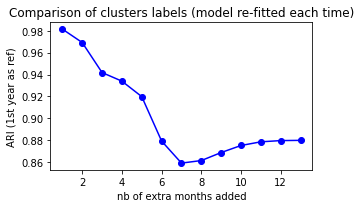

In [109]:
fig = plt.figure(figsize=(5,3))

ax = fig.add_subplot(111)
ax.plot(range(1, 14), ser_ARI_1_month.values, '-ob')
ax.set_xlabel('nb of extra months added')
ax.set_ylabel('ARI (1st year as ref)')
plt.title('Comparison of clusters labels (model re-fitted each time)')
plt.tight_layout()
plt.show()

Clusters tend to change more when more time elapses, however, ARI scores greater than 0.95 show that customers remain mostly is the same clusters.

Let's visualize now the flows of customers from one period to another with a Sankey diagram.

In [110]:
# Computing flow data and plotting the Sankey diagram
title="Sankey Diagram showing flows of customers from one period to another\
 - (model refitted for each period)"
all_flows = plot_Sankey_diagram(df_clust_1st_year, title=title)

## 3 Selection A: quantile transformer (UMAP transformation

In [111]:
# Data selection
sel_cols_A = ['mean_prod_descr_length', 'mean_prod_wei_g', 'mean_prod_vol_cm3',
              'mean_ship_delay', 'avg_freight_payval_ratio', 'nb_not_rec_orders',
              'tot_comment_length','mean_rev_score', 'time_since_last_purch',
              'tot_price', 'mean_nb_items_per_ord', 'tot_nb_deliv_ord',
              'mean_pay_install']

dfA_trans, dfA = select_transform(df_cust, sel_cols_A, strat_quant='quant_norm',
                                  UMAP_transf=True, n_comp=6)

ooooooooooooo- UNTRANSFORMED DATA (df_expl) -ooooooooooooo


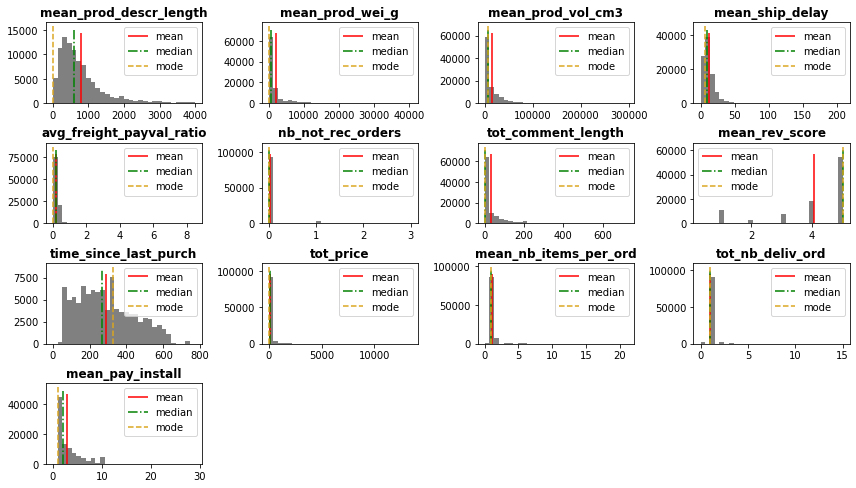

ooooooooooooo- TRANSFORMED DATA (df) -ooooooooooooo


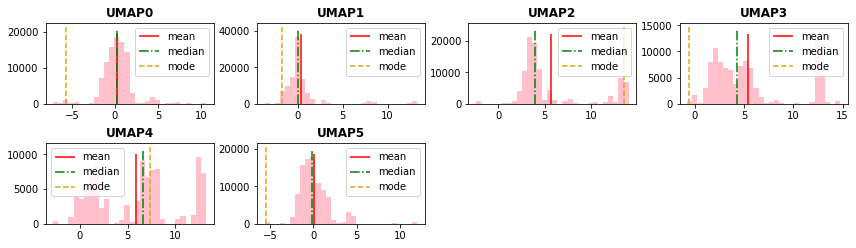

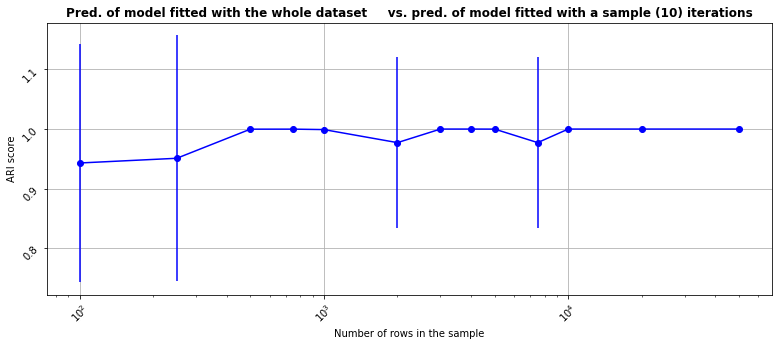

Please, choose a convenient sample size: 3000


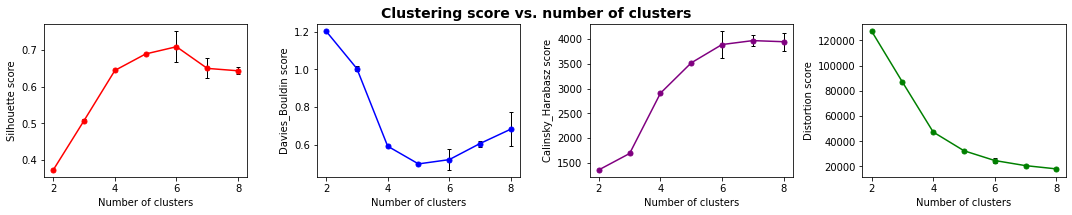

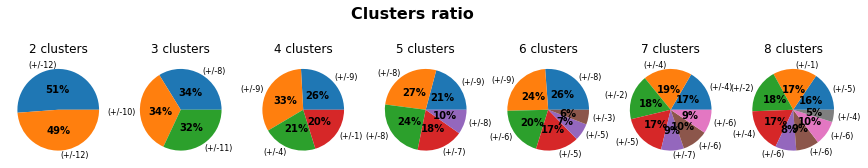

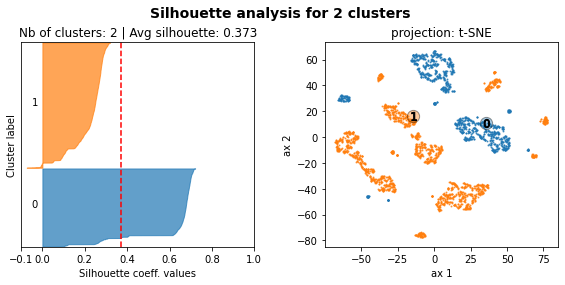

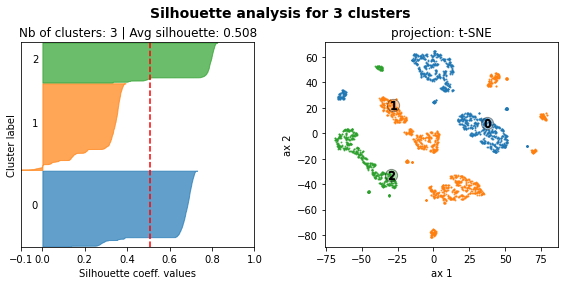

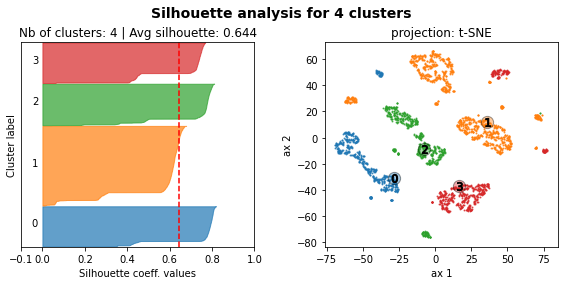

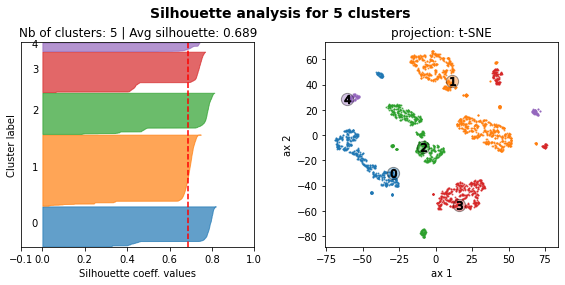

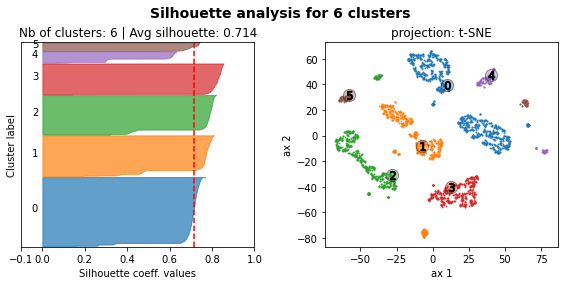

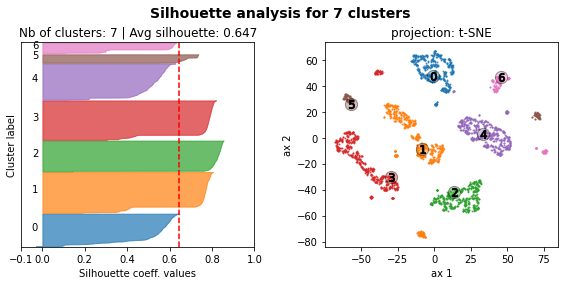

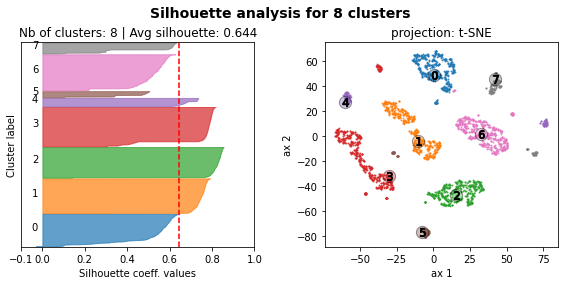

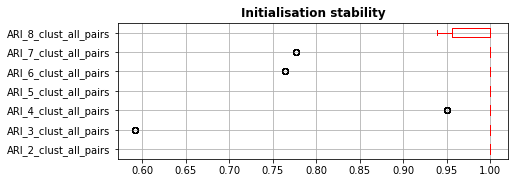

Please, choose the number of     clusters for the best model: 5
scores of the best model : 
 silh=0.6892440319061279,     cal_har=3519.4805778075456, dav_bould=0.49818721548378414, distor=32451.659193035062


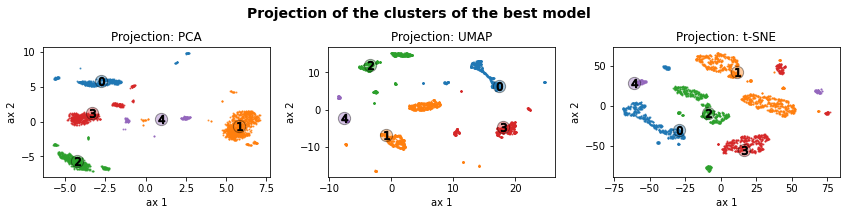

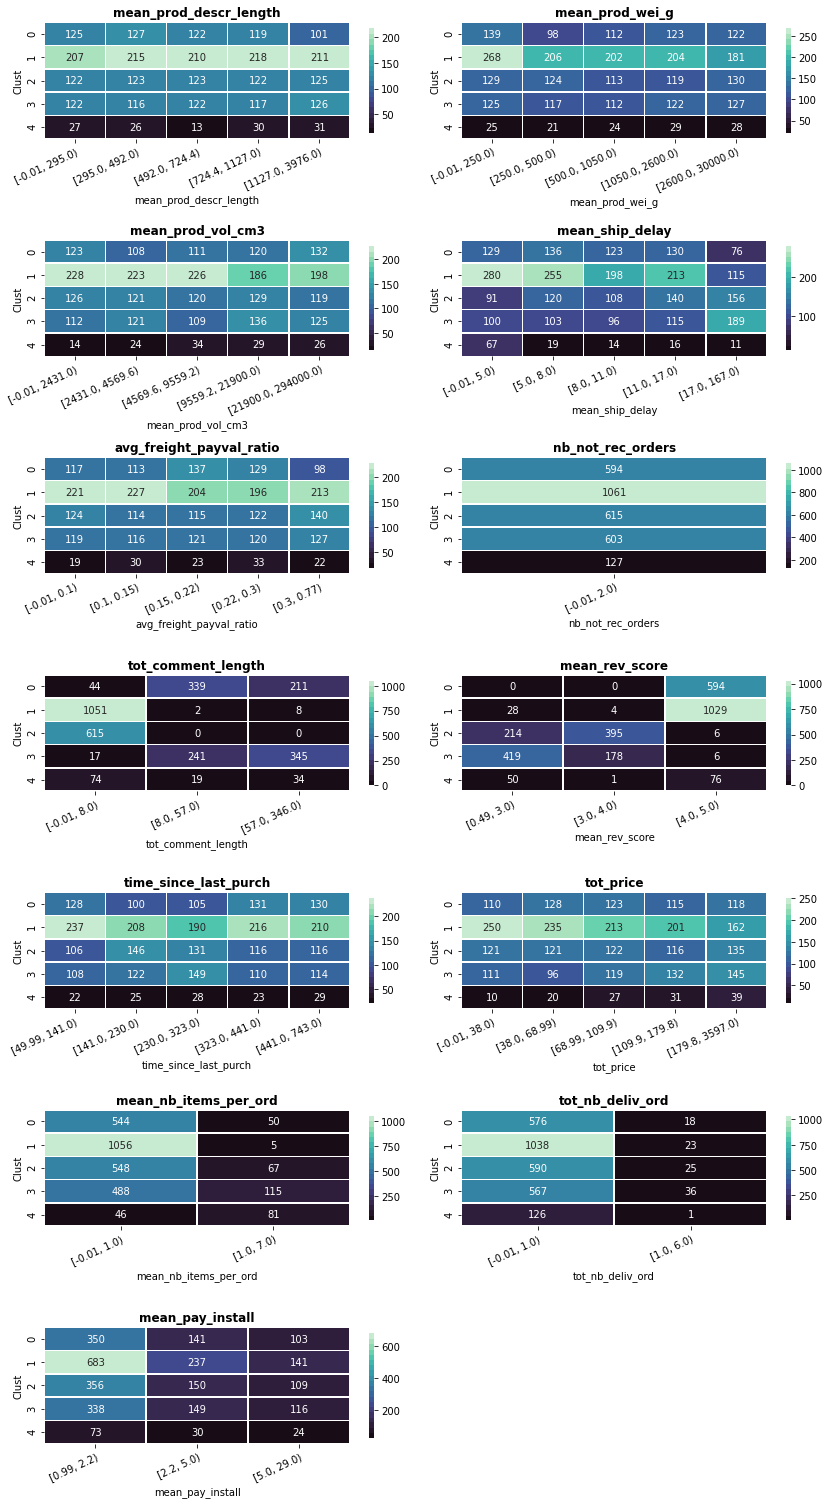

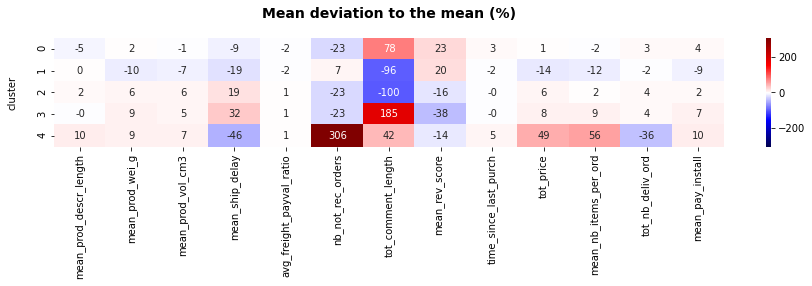

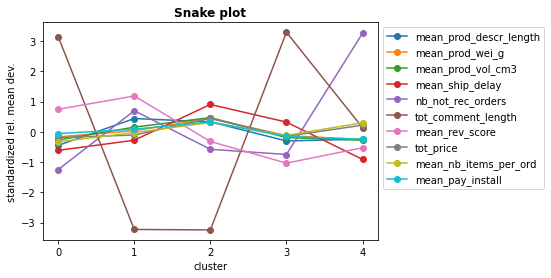

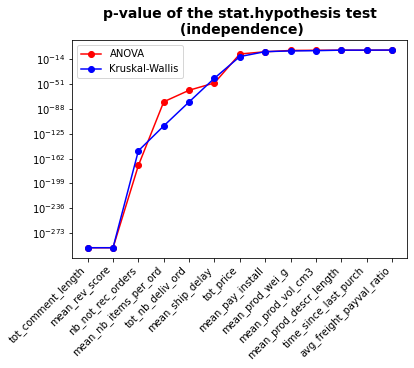

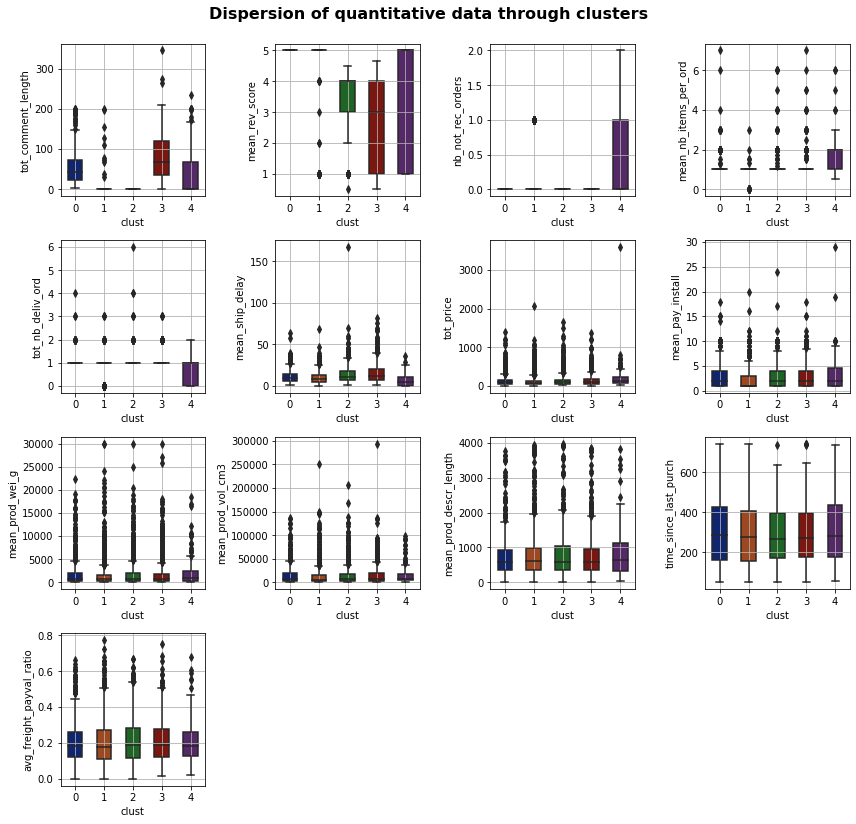

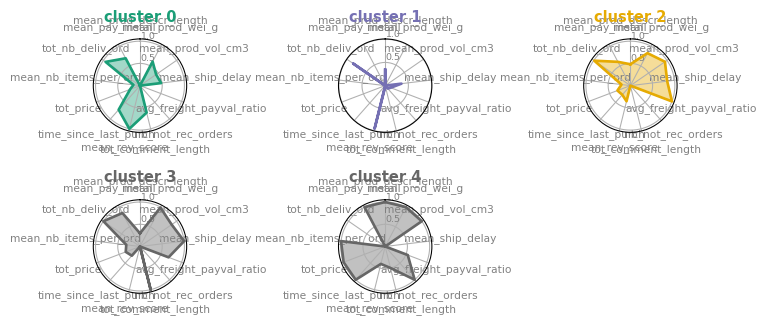

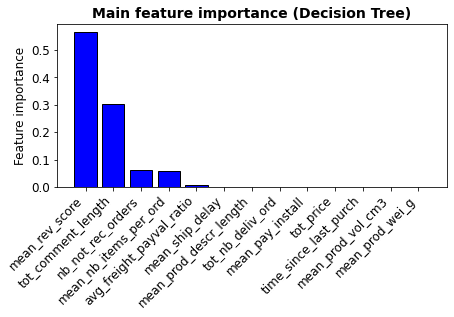

In [114]:
kmeans_clustering_all_steps(df=dfA_trans, df_expl=dfA)

Method 1: Following customers of the first year with the same model (using .predict)


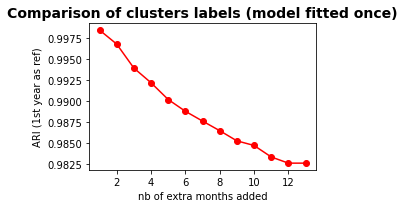

Method 2: Following customers of the first year with the same model (using .predict)


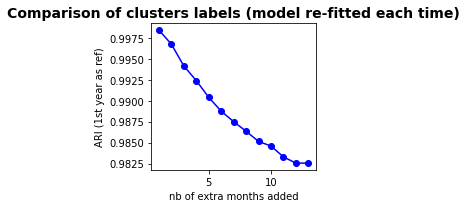

In [119]:
params_sel_trans = {'sel_cols': sel_cols_A ,
                    'strat_quant': 'quant_norm',
                    'UMAP_transf': True,
                    'n_comp': 6}
dict_df_trans, dict_df_orig = \
    sel_trans_dict_periods(dict_df_cust, **params_sel_trans, print_opt=False)

stability_through_time(dict_df_trans, n_clust, method1=True, method2=True)